In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

RuntimeError: KeyboardInterrupt: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CHF=X.csv')

In [4]:
df['Date'] = pd.to_datetime(df['Date'])

#check for missing values
print(f'Nb Nan: {np.isnan(df.Close.values).sum()}')

#substitue missing values with interpolation
df['Close'] = df.Close.interpolate(method='linear')

#check again
#check for missing values
print(f'Nb Nan: {np.isnan(df.Close.values).sum()}')


Nb Nan: 1
Nb Nan: 0


In [5]:
#construct a time series of exchange rate USD/CHF
series = df[['Date', 'Close']]

#construct a time series of log retrunrs over the USD/CHF exchange rate
lret = np.log(series['Close']/series['Close'].shift(1))

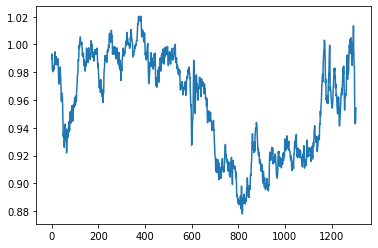

In [6]:
plt.plot(series['Close'])

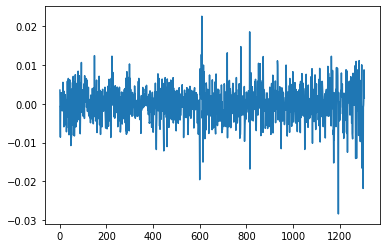

In [7]:
plt.plot(lret)

For the following analysis we are going to focus on log returns of the exchange rate

In [8]:
lret = pd.DataFrame(lret[1:])
lret['Date'] = series['Date'][1:]

#NOTE: in our series there is 2020 which is a leap year so we dorp the last day of February for that year
lret = lret.drop(lret[lret['Date'] == '2020-02-28'].index)

In [9]:
#Here we look for possible seasonality on the data
lret['year'] = [d.year for d in lret.Date]
lret['month'] = [d.strftime('%b') for d in lret.Date]
#Get the number of years that are beeig considered
years = lret['year'].unique()
month = lret['month'].unique()
month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug', 'Sep', 'Oct', 'Nov', 'Dec' ]

month

array(['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
       'Aug', 'Sep', 'Oct'], dtype=object)

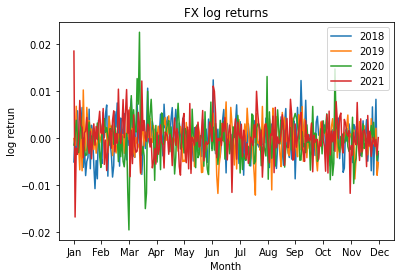

In [100]:
#Plot the time series per each year to study possible seasonality
for ind, y in enumerate(years):
  x = np.arange(len(lret.loc[lret.year == 2021, :].Close))
  

  if (ind>0 and ind<(len(years)-1)):
    plt.plot(x, lret.loc[lret.year == y, :].Close, label = y)
    plt.legend()
    plt.title('FX log returns')
    plt.xlabel('Month')
    plt.ylabel('log retrun')
    plt.xticks(np.linspace(0, 261, 12, dtype =int), month_list)

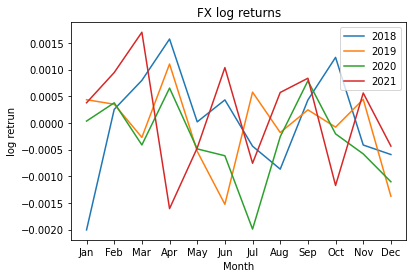

In [101]:
#we look at some summary statisitc such as the mean value for each year

for ind, y in enumerate(years):
  if (ind>0 and ind<(len(years)-1)):
    monthly_means = lret.loc[lret.year == y, :].groupby('month').mean().loc[month_list].Close
    plt.plot(month_list, monthly_means, label=y)
    plt.legend()
    plt.title('FX log returns')
    plt.xlabel('Month')
    plt.ylabel('log retrun')

From the graph we can note the absence of correspondence of peaks between the different years which suggests that there is no seasonality in this series. In addition nothing suggests the presence of a trend.
We can also note that the graphs indicate a possible stationarity.

Following we will focus on studing wheter the time series is stationary or not. To do so we will use the ADF (Augmented Dickey Fuller) test. Testing for differnt number of lags

In [12]:
#here we apply the ADF test
from statsmodels.tsa.stattools import adfuller

result = adfuller(lret.Close.values, maxlag=10)


print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}\n')

for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -34.07086453275941
p-value: 0.0

Critial Values:
   1%, -3.435378572037035
Critial Values:
   5%, -2.863760700696655
Critial Values:
   10%, -2.56795231450063


We finde that we can reject the null hypothesis of unit root so the series is stationary 
(note:there might be a probelm sice the test for result[0] (p-value < 0.01) gives 0 lags used)

Further we will consider an ARIMA(p,q) model and study the numebr of lag that is composed of

In [83]:
#First we can trivially look at an OLS regression and check the signiifcane of the coefficetns for the laged parameters

lag = 5
endog = pd.DataFrame()
endog['exog'] =  lret.iloc[lag: , : ].Close.values

for ind in range(1, lag+1):
  endog[f'lag-{ind}'] = lret.iloc[lag-ind: -ind].Close.values



In [88]:
import pandas as pd
import statsmodels.formula.api as sm
result = sm.ols(formula='exog ~ Q("lag-1") + Q("lag-2") + Q("lag-3") + Q("lag-4")', data=endog).fit()
#print(result.params)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   exog   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.076
Date:                Thu, 24 Nov 2022   Prob (F-statistic):              0.367
Time:                        10:18:58   Log-Likelihood:                 5201.7
No. Observations:                1299   AIC:                        -1.039e+04
Df Residuals:                    1294   BIC:                        -1.037e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.372e-05      0.000     -0.112      0.911      -0.000       0.000
Q("lag-1")     0.0562      0.028      2.023      0.043       0.002       0.111
Q("lag-2")     0.0073      0.028      0.262      0.793      -0.047       0.062
Q("lag-3")     0.0046      0.028      0.165      0.869      -0.050       0.059
Q("lag-4")    -0.0055      0.028     -0.199      0.842      -0.060       0.049
==============================================================================
Omnibus:                      128.665   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              542.376
Skew:                          -0.381   Prob(JB):                    1.68e-118
Kurtosis:                       6.072   Cond. No.                         236.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The results of the regression would suggest that the lag varaibles are not significat. But this might be justifed by the fact that the realtion in the lag values is not linear

We further explore the possibility of considering an ARIMA(p,q) model by studing the possible values of p and q throught the ACF (autocorrelation function) and PACF (partial autocorrelation function)

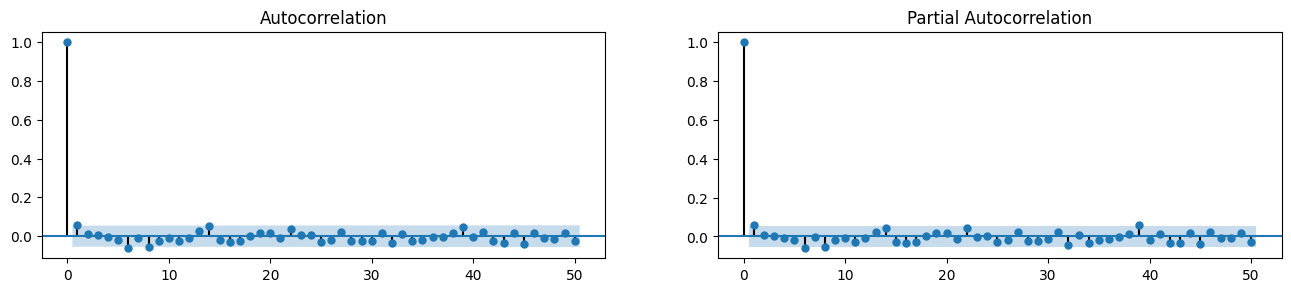

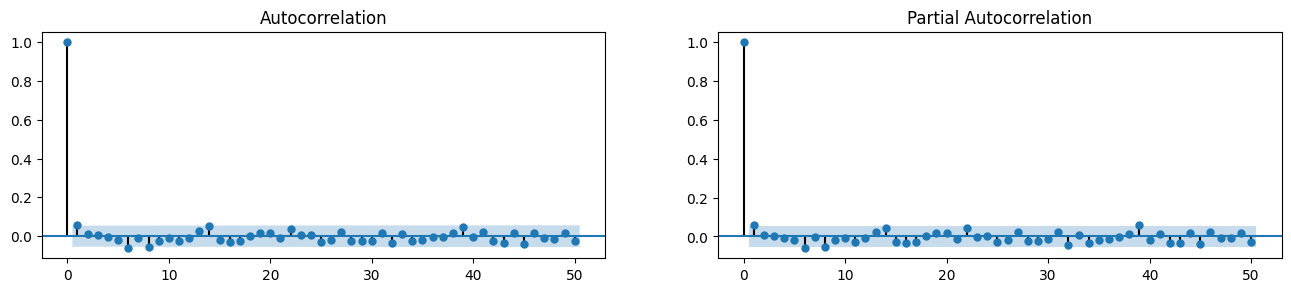

In [99]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Calculate ACF and PACF upto 50 lags
#acf_50 = acf(lret.Close, nlags=50)
#pacf_50 = pacf(lret.Close, nlags=50)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(lret.Close.values.tolist(), lags=50, ax=axes[0])
plot_pacf(lret.Close.values.tolist(), lags=50, ax=axes[1])

Unfortunately both function suggest p=0 and q=0;

Using ARIMA model fails to provide us with relevant information on the number of lages that we should use for our networks. 

A positive note is that the time series of log returns of the FX appears to be stationary.
